In [1]:
#Dataframe
import pandas as pd
import numpy as np
import math
from datetime import datetime
import scipy
from scipy import stats
#Graph
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
#sklearn & models
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import time
#Data processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from  sklearn.impute import SimpleImputer   
from imblearn.over_sampling import SMOTE
#Print max 30 lines in each cell
pd.set_option('display.max_rows', 30)

In [11]:
#   Load dataframe
df = pd.read_csv("./data/application_train.csv" )           #index_col=0  ID which is used for mapping other excel files goes to index column
print('original shape: ' , df.shape)
df.drop(columns=['SK_ID_CURR','DAYS_BIRTH'], inplace=True)  #drop ID

#   Handle columns with missing values: Exceed drop rate will be filled in by mostly appearing values, it will otherwise be dropped. 
drop_rate = 0.2   #1 means drop nothing    #0.3 mean the data with 70% more  
drop_col_Cat = drop_col_Num = drop_col_Corr = []
#   Drop categorical columns with many missing values
for col in df.columns:
    if (df[col].isna().sum() / df.shape[0] <= drop_rate )&(type(df[col][0])==str):
        df[col].fillna(  df[col].mode()[0]  ,inplace=True)  #   >>>categorical columns<<<   Minor missing values: replace with mode
    elif (df[col].isna().sum() / df.shape[0] > drop_rate )&(type(df[col][0])==str):
        drop_col_Cat.append(col)                          #   >>>categorical columns<<<   Huge missing values:  drop
df.drop(columns=drop_col_Cat , inplace=True)
#   Drop numerical columns with many missing values
drop_col_Num = [col for col in df.columns if (df[col].isna().sum() / df.shape[0] > drop_rate )&((type(df[col][0])==np.int64)|(type(df[col][0])==np.float64))]
df.drop(columns=drop_col_Num , inplace=True)    
#   Replace missing values with mean
df[list(df.select_dtypes(include=["int64","float64"]).columns)]  =  pd.DataFrame(   SimpleImputer(missing_values=np.NaN, strategy='mean').fit_transform(  df[list(df.select_dtypes(include=["int64","float64"]).columns)].values),index = df.index,columns=  list(df.select_dtypes(include=["int64","float64"]).columns) )      # 

print('Columns that is dropped due to missing values with % of less than',drop_rate,': \n','Cat: ',drop_col_Cat,'\nNum: ',drop_col_Num,'\nCorr: ',drop_col_Corr)

#   Imbalanced dataset stragegy: Downscale to the less dataset with label (0) which is faulty loan
df.drop(df.query('TARGET == 0').sample(((df.query('TARGET == 0').shape[0])-1*(df.query('TARGET == 1').shape[0]))).index,inplace=True)  #Downscale the data with '0'
print(df.TARGET.value_counts())

#   Splitting for model
X = df.drop(columns=['TARGET'])
y = df[['TARGET']]

#   Normalization on numerical columns
from sklearn.preprocessing import StandardScaler
for col in list(X.select_dtypes(include=["int64","float64"]).columns):
    X[[col]]=StandardScaler().fit_transform(X[[col]])

#   One Hot Encoder on categorical columns
X= pd.get_dummies(X, drop_first=True)       

print('X.shape = ' , X.shape)
X.head()

original shape:  (307511, 122)
Columns that is dropped due to missing values with % of less than 0.2 : 
 Cat:  ['OCCUPATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'] 
Num:  ['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOOR

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,-0.591841,0.066868,-0.457957,-0.157656,-0.477911,-0.092971,-0.414674,0.320148,0.498156,0.0,...,0,0,0,0,0,0,0,0,0,0
8,-0.591841,-0.102166,1.165302,0.513786,1.156465,-0.105822,2.347760,-0.781869,-0.419630,0.0,...,0,0,0,0,0,0,0,0,0,1
9,-0.591841,-0.059907,-0.462187,-0.485100,-0.321011,-0.024635,-0.425108,-2.826099,-0.734337,0.0,...,0,0,0,0,0,0,0,0,0,0
11,-0.591841,-0.241300,-1.141757,-1.189319,-1.105511,-0.368470,2.347760,-0.145854,0.240070,0.0,...,0,0,0,0,0,0,0,0,0,1
12,-0.591841,-0.186682,-1.320497,-1.542257,-1.301636,0.871121,-0.430378,1.293272,-0.230674,0.0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
import time
start_time = time.time()

print('-------RamdonForest (200 estimators)-------')
#   Finding 1:      No change when we remove columns with relatively low correlation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42 , stratify=y)

rnd_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42 )  #, max_leaf_nodes=16, bootstrap=False
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

#Step 6:    Classification Metrics        #---------------------Score---------------------#
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)

print("Process finished --- %s seconds ---" % (time.time() - start_time))

-------RamdonForest (200 estimators)-------
confusion_matrix:    
 [[6819 3111]
 [3209 6721]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.68      0.69      0.68      9930
         1.0       0.68      0.68      0.68      9930

    accuracy                           0.68     19860
   macro avg       0.68      0.68      0.68     19860
weighted avg       0.68      0.68      0.68     19860

accuracy_score:  
 0.6817724068479355  ; with data size of  (29790, 150)
Process finished --- 5.397893905639648 seconds ---


In [13]:
import time
start_time = time.time()

print('-------RamdonForest (2000 estimators)-------')
#   Finding 1:      No change when we remove columns with relatively low correlation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42 , stratify=y)

rnd_clf = RandomForestClassifier(n_estimators=2000, n_jobs=-1, random_state=42 )  #, max_leaf_nodes=16, bootstrap=False
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

#Step 6:    Classification Metrics        #---------------------Score---------------------#
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)

print("Process finished --- %s seconds ---" % (time.time() - start_time))

-------RamdonForest (2000 estimators)-------
confusion_matrix:    
 [[6824 3106]
 [3152 6778]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.68      0.69      0.69      9930
         1.0       0.69      0.68      0.68      9930

    accuracy                           0.68     19860
   macro avg       0.68      0.68      0.68     19860
weighted avg       0.68      0.68      0.68     19860

accuracy_score:  
 0.6848942598187311  ; with data size of  (29790, 150)
Process finished --- 56.33970308303833 seconds ---


In [14]:
from sklearn.decomposition import PCA

pca = PCA()  
X_train = pca.fit_transform(X_train)  
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_  
print(explained_variance)

[6.50374271e-02 5.70359694e-02 5.38523254e-02 4.25877922e-02
 3.71528892e-02 3.07953942e-02 2.66321192e-02 2.63763306e-02
 2.42350047e-02 2.37773144e-02 2.26586138e-02 2.14359528e-02
 2.08324700e-02 2.06069630e-02 1.95599504e-02 1.90996356e-02
 1.89678727e-02 1.83273630e-02 1.79838340e-02 1.77523403e-02
 1.74959148e-02 1.73204683e-02 1.71842946e-02 1.70408368e-02
 1.69234763e-02 1.65616183e-02 1.64287471e-02 1.61397010e-02
 1.58539340e-02 1.55446700e-02 1.51197871e-02 1.48727412e-02
 1.44302032e-02 1.44135601e-02 1.43606593e-02 1.37046306e-02
 1.27965653e-02 1.20729604e-02 1.19768823e-02 1.13583871e-02
 1.10089715e-02 1.03334369e-02 9.94999608e-03 6.01039004e-03
 5.45373491e-03 5.33926578e-03 4.28183597e-03 4.08501446e-03
 3.77524517e-03 3.60726836e-03 3.57889035e-03 3.29526783e-03
 3.13887250e-03 3.02307159e-03 2.87884429e-03 2.82874761e-03
 2.54732363e-03 2.12448983e-03 2.08178194e-03 1.99713948e-03
 1.81437535e-03 1.64158061e-03 1.43461721e-03 1.07379717e-03
 9.12705164e-04 8.969715

In [15]:
import time
start_time = time.time()

print('-------XGboost-------')
#Finding1:  SMOTE: too many False Negative
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size =0.2, random_state=42, stratify = y)
print(X.shape)

model =XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Classification Metrics
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)


print("Process finished --- %s seconds ---" % (time.time() - start_time))

-------XGboost-------
(49650, 150)
[12:35:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion_matrix:    
 [[3411 1554]
 [1576 3389]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.68      0.69      0.69      4965
         1.0       0.69      0.68      0.68      4965

    accuracy                           0.68      9930
   macro avg       0.68      0.68      0.68      9930
weighted avg       0.68      0.68      0.68      9930

accuracy_score:  
 0.6847935548841894  ; with data size of  (39720, 150)
Process finished --- 6.980496644973755 seconds ---


In [16]:
from sklearn import preprocessing
#get_score identifies the features that the model put the highest weight on
importance_df = model.get_booster().get_score(importance_type='weight')

features_impt_xgb = pd.DataFrame(list(importance_df.items()), columns = ['FEATURE' , 'SCORE'])

print(features_impt_xgb.sort_values('SCORE', ascending = False).head(10))

                       FEATURE  SCORE
1                 EXT_SOURCE_2    379
14             DAYS_ID_PUBLISH    362
5                  AMT_ANNUITY    325
7                DAYS_EMPLOYED    315
4            DAYS_REGISTRATION    303
0                 EXT_SOURCE_3    286
10      DAYS_LAST_PHONE_CHANGE    277
17                  AMT_CREDIT    247
11            AMT_INCOME_TOTAL    187
9   REGION_POPULATION_RELATIVE    184


In [17]:
print('-------LogisticRegression-------')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)       #
print('X_train shape is:  ', X_train.shape)

logmodel = LogisticRegression()     # Create instance (i.e. object) of LogisticRegression
logmodel.fit(X_train, y_train)      # Fit the model using the training data
y_pred = logmodel.predict(X_test)   #Predicting the target for test data

#Classification Metrics
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)

-------LogisticRegression-------
X_train shape is:   (39720, 150)
confusion_matrix:    
 [[3426 1539]
 [1544 3421]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.69      0.69      0.69      4965
         1.0       0.69      0.69      0.69      4965

    accuracy                           0.69      9930
   macro avg       0.69      0.69      0.69      9930
weighted avg       0.69      0.69      0.69      9930

accuracy_score:  
 0.6895266868076536  ; with data size of  (39720, 150)


In [18]:
print('-------LogisticRegression ( low classifier to reduce over fitting)-------')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)       #
print('X_train shape is:  ', X_train.shape)

logmodel = LogisticRegression(C = 0.0001)     # Create instance (i.e. object) of LogisticRegression
logmodel.fit(X_train, y_train)      # Fit the model using the training data
y_pred = logmodel.predict(X_test)   #Predicting the target for test data

#Classification Metrics
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)

-------LogisticRegression ( low classifier to reduce over fitting)-------
X_train shape is:   (39720, 150)
confusion_matrix:    
 [[3381 1584]
 [1588 3377]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      4965
         1.0       0.68      0.68      0.68      4965

    accuracy                           0.68      9930
   macro avg       0.68      0.68      0.68      9930
weighted avg       0.68      0.68      0.68      9930

accuracy_score:  
 0.6805639476334341  ; with data size of  (39720, 150)


In [20]:
print('-------KNN-------')
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)       #
#SMOTE: too slow , run like 1 hour for data set with ~300k size

k = 5
knn = KNeighborsClassifier(n_neighbors=k)   #Make an object
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)

#Classification Metrics
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)
print("Process finished --- %s seconds ---" % (time.time() - start_time))

-------KNN-------
confusion_matrix:    
 [[2945 2020]
 [1882 3083]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.61      0.59      0.60      4965
         1.0       0.60      0.62      0.61      4965

    accuracy                           0.61      9930
   macro avg       0.61      0.61      0.61      9930
weighted avg       0.61      0.61      0.61      9930

accuracy_score:  
 0.6070493454179254  ; with data size of  (39720, 150)
Process finished --- 10.183549642562866 seconds ---


[0.5756294058408862, 0.5731117824773414, 0.5937562940584089, 0.5932527693856999, 0.6070493454179254, 0.6071500503524673, 0.6133937562940585, 0.6173212487411883, 0.6229607250755287, 0.6191339375629406, 0.6246727089627392, 0.6248741188318228, 0.6273917421953675, 0.6247734138972809, 0.6277945619335348, 0.6283987915407855, 0.6314199395770392, 0.6307150050352467, 0.6361530715005035, 0.633031218529708, 0.6359516616314199, 0.6324269889224572, 0.6355488418932528, 0.6355488418932528, 0.6365558912386707, 0.6366565961732125, 0.637865055387714, 0.6357502517623363, 0.6369587109768379, 0.6382678751258811]


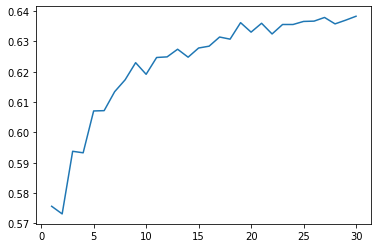

In [22]:
k_range = range(1,31)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred_knn))
print(scores)
plt.plot(k_range,scores)

In [23]:
print('AdaBoost (unlimitted depth and leaf)')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 , stratify=y)

ada_clf = AdaBoostClassifier(
    #DecisionTreeClassifier(max_depth=2), n_estimators=200,learning_rate=0.05, random_state=42)
    DecisionTreeClassifier(), n_estimators=200,learning_rate=0.05, random_state=42)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)

#5.1 - Hyperparameter Tuning (Max Depth)#---------------------Modelling---------------------#  Find Max depth
parameters = {'max_depth' : list(range(1,11))}
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(DecisionTreeClassifier(),param_grid=parameters,cv=10)
search.fit(X_train,y_train)
print('search.best_score_:' , search.best_score_)
print('search.best_params_:', search.best_params_)

#Classification Metrics
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)

AdaBoost (unlimitted depth and leaf)
search.best_score_: 0.6502769385699898
search.best_params_: {'max_depth': 4}
confusion_matrix:    
 [[2934 2031]
 [2036 2929]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.59      0.59      0.59      4965
         1.0       0.59      0.59      0.59      4965

    accuracy                           0.59      9930
   macro avg       0.59      0.59      0.59      9930
weighted avg       0.59      0.59      0.59      9930

accuracy_score:  
 0.5904330312185297  ; with data size of  (39720, 150)


In [10]:
print('LGBMClassifier')

LGBMClassifier


In [24]:
#Presentation (Correlation) ------------ part 1
df = pd.read_csv("./data/application_train.csv" )
df_corr = pd.DataFrame( df.corr()['TARGET'])
df_corr['MissingValue'] = [df[list(df_corr.index)[x]].isna().sum() for x in range(len(pd.DataFrame(df_corr)['TARGET']))]
#df_corr = df_corr[df_corr['MissingValue']>30000].sort_values(by=['TARGET'])
df_corr['Abs_correlation'] = abs(df_corr['TARGET'])
df_corr.sort_values(by=['Abs_correlation'],ascending=False,inplace=True)
#"','".join(list(df_corr.index))

#Presentation (Correlation) ------------ part 2
df_corr_top20 = df_corr[(df_corr['Abs_correlation']>=   df_corr.iloc[19,2]    )]    #Get top 20
df_corr_top20.drop('TARGET',inplace=True)
df_corr_top20.columns=['Correlation','Count_MissingValues','Abs_correlation']
print(df_corr_top20)

                             Correlation  Count_MissingValues  Abs_correlation
EXT_SOURCE_3                   -0.178919                60965         0.178919
EXT_SOURCE_2                   -0.160472                  660         0.160472
EXT_SOURCE_1                   -0.155317               173378         0.155317
DAYS_BIRTH                      0.078239                    0         0.078239
REGION_RATING_CLIENT_W_CITY     0.060893                    0         0.060893
REGION_RATING_CLIENT            0.058899                    0         0.058899
DAYS_LAST_PHONE_CHANGE          0.055218                    1         0.055218
DAYS_ID_PUBLISH                 0.051457                    0         0.051457
REG_CITY_NOT_WORK_CITY          0.050994                    0         0.050994
FLAG_EMP_PHONE                  0.045982                    0         0.045982
DAYS_EMPLOYED                  -0.044932                    0         0.044932
REG_CITY_NOT_LIVE_CITY          0.044395            

<AxesSubplot:>

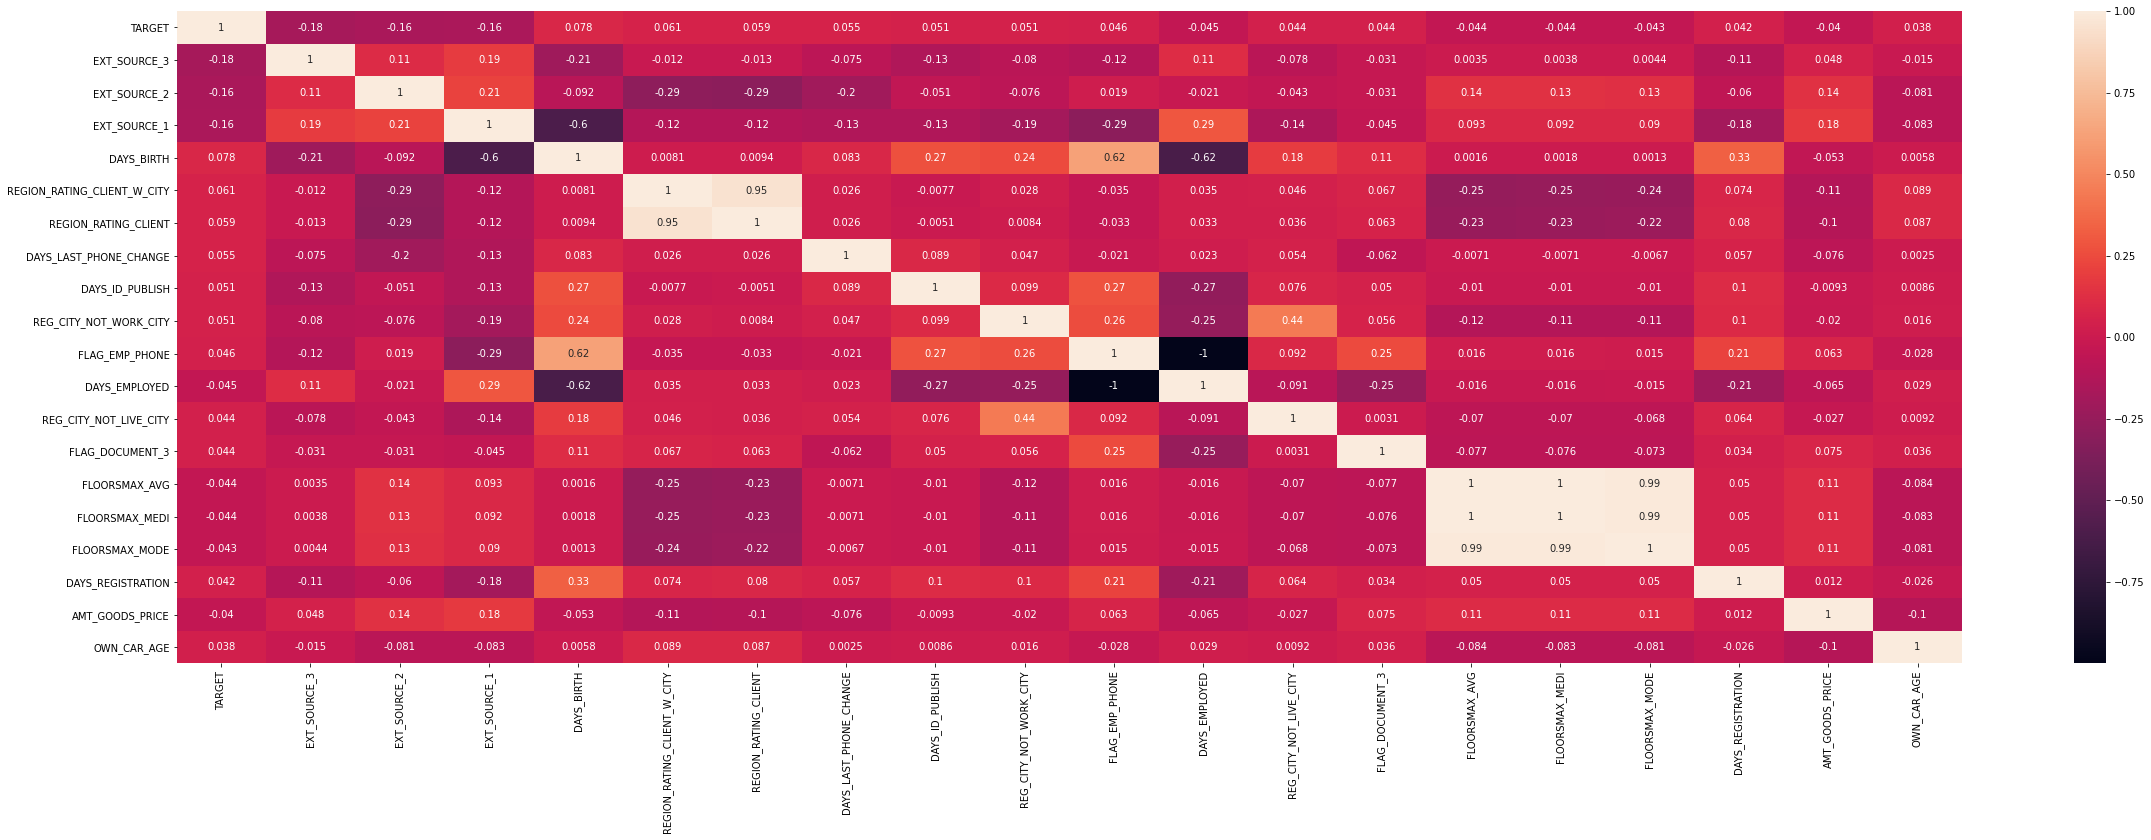

In [25]:
#Heatmap for correlation
top20 = list(df_corr_top20.index)
df_top20 = df[top20]
df_top20.insert(0, 'TARGET', df['TARGET'])
plt.figure(figsize=(40,12))
sns.heatmap(df_top20.corr(),annot=True)

<AxesSubplot:xlabel='MissingValue', ylabel='Feature'>

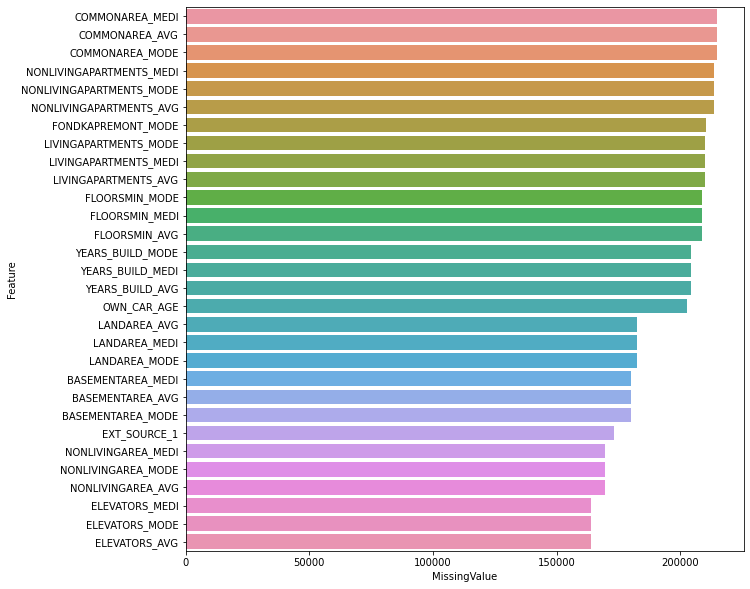

In [26]:
#Presentation (Missing Values) 
df = pd.read_csv("./data/application_train.csv" )

MissingColumns = []
MissingValues = []
for col in df.columns:
    if int(df[col].isna().sum()) != 0:
        MissingColumns.append(col)
        MissingValues.append(df[col].isna().sum())
missing_df = pd.DataFrame(list(zip(MissingColumns, MissingValues)), columns =['Feature', 'MissingValue']) 
missing_df.sort_values(by=['MissingValue'],ascending=False,inplace=True)
missing_df.reset_index(drop=True, inplace=True)
#sns.factorplot(df=missing_df , x = 'MissingValue' , y = 'Feature' )
missing_df.head(30)
fig , ax = plt.subplots(figsize = (10,10))
sns.barplot(data=missing_df.head(30) , x = 'MissingValue' , y = 'Feature' )